In [63]:
import rasterio as rs
import numpy as np
import matplotlib.pyplot as plt
import math

In [64]:
# folder = '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P1/'

# gedi_path = '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P1/GEDI_2020_06_10m.tif'
# pred_path = '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P1/Download1_S2A_MSIL2A_20200218T032811_N0500_R018_T48QWJ_20230625T231344_predictions.tif'
# chm_path = '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P1/global_CHM_EPSG_32648.tif'

gedi_path = '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P2/GEDI_20200717.tif'
pred_path = '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/test/Download2_S2A_MSIL2A_20200717T032541_N0500_R018_T48QWH_20230425T174205_predictions.tif'
chm_path = '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P2/global_CHM_2020.tif'

# gedi_path =  '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P3/GEDI_20200826.tif'
# pred_path =  '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/test/Download3_S2A_MSIL2A_20200826T032541_N0500_R018_T48QWL_20230418T063839_predictions.tif'
# chm_path =  '/mnt/data2tb/global-canopy-height-model/deploy_example/predictions/2020/P3/global_CHM_2020.tif'

# Read predicted CHM and GEDI 

In [65]:
from shapely.geometry import box
import rasterio as rio

with rio.open(pred_path) as ras1, rio.open(gedi_path) as ras2:
    ext1 = box(*ras1.bounds) 
    ext2 = box(*ras2.bounds)
    intersection = ext1.intersection(ext2) 
    win1 = rio.windows.from_bounds(*intersection.bounds, ras1.transform)
    win2 = rio.windows.from_bounds(*intersection.bounds, ras2.transform)

    overlap_1 = ras1.read(window=win1)
    overlap_2 = ras2.read(window=win2)

In [66]:
pred_data = overlap_1.squeeze(0)
gedi_data = overlap_2.squeeze(0)

mask = np.isfinite(gedi_data)
pred_data = pred_data[mask]
gedi_data = gedi_data[mask]

print(gedi_data.shape, pred_data.shape)


(422572,) (422572,)


In [67]:
mask = (~np.isnan(pred_data)) & (~np.isnan(gedi_data)) & (gedi_data <= 75)
# mask = (~np.isnan(pred_data)) & (~np.isnan(gedi_data))


In [68]:
# pred_data = np.nan_to_num(pred_data)
# gedi_data = np.nan_to_num(gedi_data)
pred_data = pred_data[mask]
gedi_data = gedi_data[mask]

In [69]:
pred_data.shape, gedi_data.shape

((407485,), (407485,))

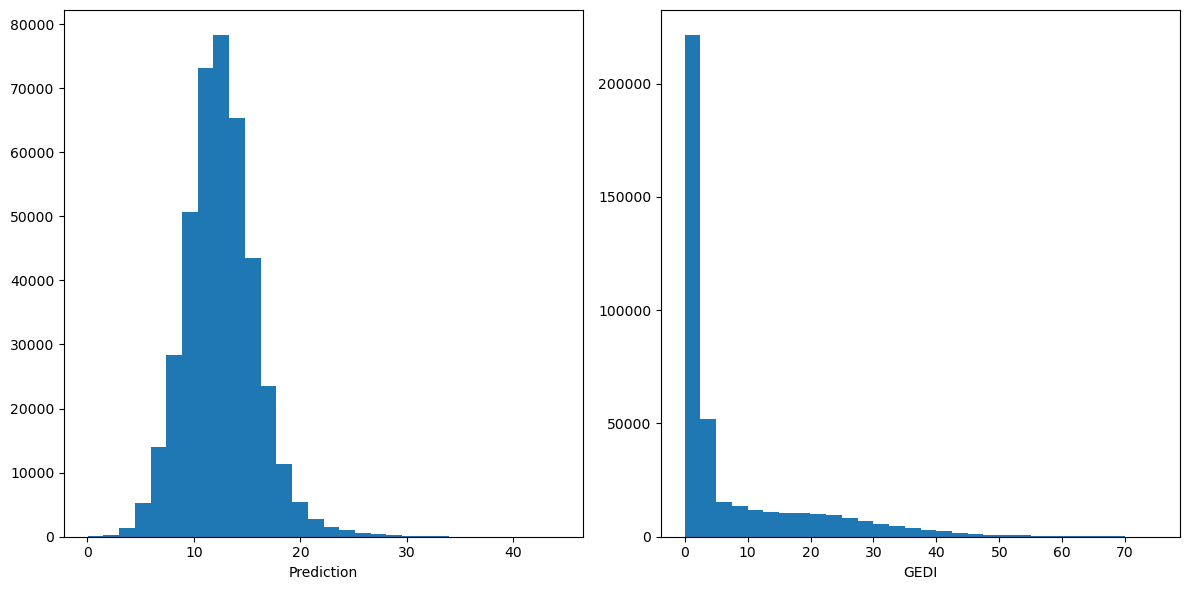

In [70]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(pred_data, bins=30)
plt.xlabel('Prediction')

plt.subplot(1,2,2)
plt.hist(gedi_data, bins=30)
plt.xlabel('GEDI')

plt.tight_layout()
plt.show()

In [71]:
np.max(pred_data)

44.333504

In [72]:
# evaluation metrics

predicted = pred_data.flatten()
ground_truth = gedi_data.flatten()

rmse = np.sqrt(np.mean((predicted - ground_truth) ** 2))
mae = np.mean(np.abs(predicted - ground_truth))
me = np.mean(predicted - ground_truth)

# print(rmse, mae, me)
print("Pred - Gedi")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"ME: {me}")


Pred - Gedi
RMSE: 13.16879624449395
MAE: 11.488487666604811
ME: 5.332263565035417


/tmp/ipykernel_24529/2151162303.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


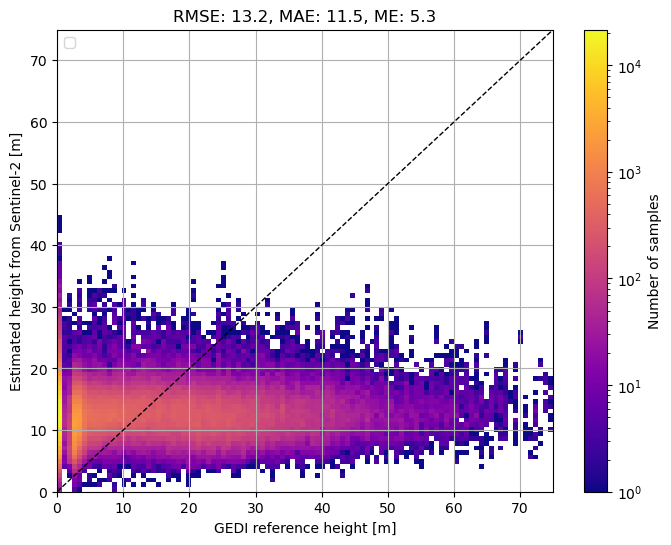

In [73]:
# draw chart
from matplotlib.colors import LogNorm  
plt.figure(figsize=(8, 6))

pred_max = np.max(predicted)
chm_max = np.max(ground_truth)
max_height = max(pred_max, chm_max)

hist, xedges, yedges, img = plt.hist2d(
    ground_truth,
    predicted,
    bins = 100,  # Number of bins
    norm = LogNorm(),  # Log scale
    cmap='plasma',  # Color map
    range = [[0, max_height], [0, max_height]]
)

# Add color bar
cbar = plt.colorbar(img)
cbar.set_label('Number of samples')

# Plot diagonal line for reference
plt.plot([0, max_height], [0, max_height], 'k--', linewidth=1)
# Add labels and titl
plt.xlabel('GEDI reference height [m]')
plt.ylabel('Estimated height from Sentinel-2 [m]')
plt.title(f'RMSE: {rmse:.1f}, MAE: {mae:.1f}, ME: {me:.1f}')
plt.legend()

# output_file = 'VN_map_S2_202006_Pred_GEDI.png'
# output_file = 'VN_map_S2_20200717_Pred_GEDI.png'
# output_file = 'case_3_pred_gedi.png' 
 
# plt.savefig(output_file, dpi=300, bbox_inches='tight') 

# Show the plot
plt.grid()
plt.show()


# Read Predicted CHM and Global CHM 2020

In [74]:
from shapely.geometry import box
import rasterio as rio

with rio.open(pred_path) as ras1, rio.open(chm_path) as ras2:
    ext1 = box(*ras1.bounds) 
    ext2 = box(*ras2.bounds)
    intersection = ext1.intersection(ext2) 
    win1 = rio.windows.from_bounds(*intersection.bounds, ras1.transform)
    win2 = rio.windows.from_bounds(*intersection.bounds, ras2.transform)

    overlap_1 = ras1.read(window=win1)
    overlap_2 = ras2.read(window=win2)

In [75]:
pred_data = overlap_1.squeeze(0)
chm_data = overlap_2.squeeze(0)

In [76]:
mask = (~np.isnan(pred_data)) & (~np.isnan(chm_data))

In [77]:
pred_data = pred_data[mask]
chm_data = chm_data[mask]

In [78]:
print(pred_data.shape, chm_data.shape)

(115898320,) (115898320,)


In [79]:
# evaluation metrics

predicted = pred_data.flatten()
ground_truth = chm_data.flatten()
rmse = np.sqrt(np.mean((predicted - ground_truth) ** 2))
mae = np.mean(np.abs(predicted - ground_truth))
me = np.mean(predicted - ground_truth)

# print(rmse, mae, me)
print("Pred - CHM")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"ME: {me}")


Pred - CHM
RMSE: 9.135016441345215
MAE: 7.2335124015808105
ME: -1.4751813411712646


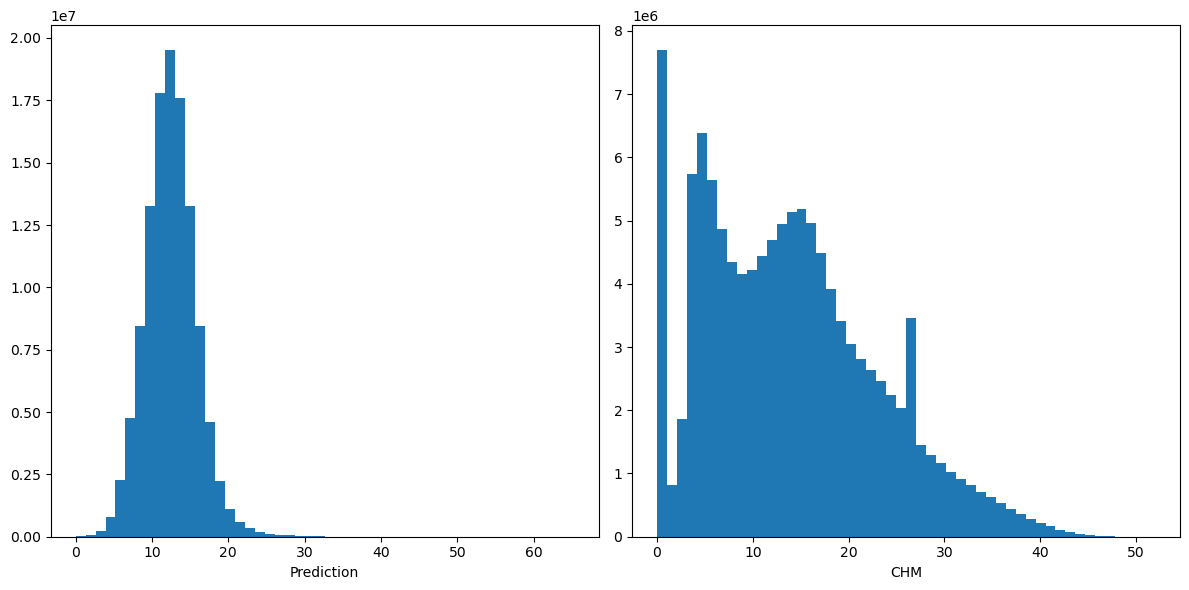

In [80]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(pred_data, bins=50)
plt.xlabel('Prediction')

plt.subplot(1,2,2)
plt.hist(chm_data, bins=50)
plt.xlabel('CHM')

plt.tight_layout()
plt.show()

/tmp/ipykernel_24529/2889770488.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


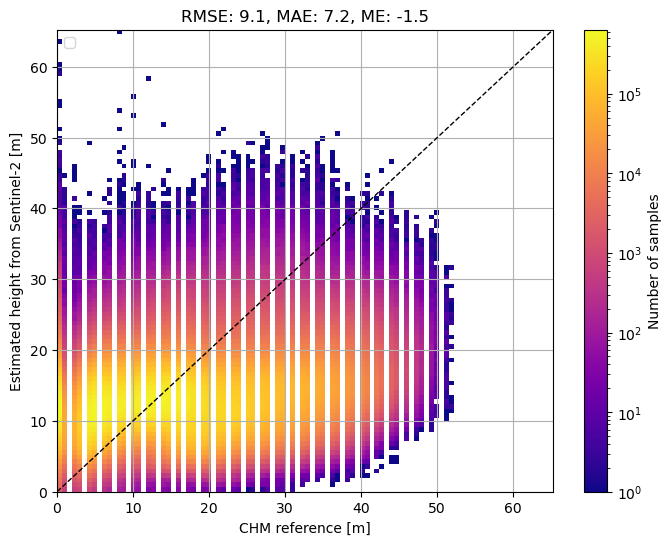

In [81]:
# draw chart
from matplotlib.colors import LogNorm  
plt.figure(figsize=(8, 6))

pred_max = np.max(predicted)
chm_max = np.max(ground_truth)
max_height = max(pred_max, chm_max)
 
hist, xedges, yedges, img = plt.hist2d(
    ground_truth,
    predicted,
    bins = 100,  # Number of bins
    norm = LogNorm(),  # Log scale
    cmap='plasma',  # Color map
    range = [[0, max_height], [0, max_height]]
)

# Add color bar
cbar = plt.colorbar(img)
cbar.set_label('Number of samples')

# Plot diagonal line for reference
plt.plot([0, max_height], [0, max_height], 'k--', linewidth=1)

# Add labels and title
plt.xlabel('CHM reference [m]')
plt.ylabel('Estimated height from Sentinel-2 [m]')
plt.title(f'RMSE: {rmse:.1f}, MAE: {mae:.1f}, ME: {me:.1f}')
plt.legend()

# output_file = 'case_3_pred_chm.png' 
# plt.savefig(output_file, dpi=300, bbox_inches='tight') 

# Show the plot
plt.grid()
plt.show()
